In [1004]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from statsmodels.tsa.seasonal import STL

One timely time series data to model at the time of writing this is dengue cases, at the moment of writing this dengue cases are on a rapid rise and having a predictive model of this disease will be beneficial for healthcare organization in preparing for outbreaks such as we are experiencing now. The dengue dataset we are going to use is from Department of Health Epidemiology Bureau (https://data.humdata.org/dataset/philippine-dengue-cases-and-deaths). The data contains information about dengue cases and deaths from 2016 to 2021, however, little to no dengue cases was recorded starting Marth of 2020 which coincide with the Covid-19 outbreak and subsequent lockdowns. Hence, we will only consider data from 2016 to end of February 2020 as the data from Marth 2020 onwards will be gravely affected by the pandemic. The dataset contains 5 non-index columns which includes 

Exploring the structure of the dataset

Properly formatting the data

In [1005]:
data = pd.read_csv("doh-epi-dengue-data-2016-2021.csv")
data.drop([0],inplace=True)
data['cases'] = pd.to_numeric(data['cases'])
data.dropna(inplace=True)
data.head()

,loc,cases,deaths,date,Region
1,ALBAY,15,0,1/10/2016,REGION V-BICOL REGION
2,ALBAY,13,0,1/17/2016,REGION V-BICOL REGION
3,ALBAY,9,0,1/24/2016,REGION V-BICOL REGION
4,ALBAY,14,0,1/31/2016,REGION V-BICOL REGION
5,ALBAY,9,0,2/7/2016,REGION V-BICOL REGION


In [1006]:
len(data['loc'].unique())

126

In [1007]:
NCR_data = data[data['Region'] == 'NATIONAL CAPITAL REGION']
NCR_cities = list(data[data['Region'] == 'NATIONAL CAPITAL REGION']['loc'].unique())
dates = list(data['date'].unique())
neighbors = {
    'CALOOCAN CITY': ['MANILA CITY', 'NAVOTAS CITY', 'MALABON CITY', 'QUEZON CITY', 'VALENZUELA CITY'],
    'LAS PINAS CITY': ['MUNTINLUPA CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'MAKATI CITY': ['PASAY CITY', 'SAN JUAN CITY', 'PATEROS', 'TAGUIG CITY'],
    'MALABON CITY': ['CALOOCAN CITY', 'NAVOTAS CITY', 'VALENZUELA CITY', 'MANILA CITY'],
    'MANDALUYONG CITY': ['PASIG CITY', 'SAN JUAN CITY', 'MANILA CITY'],
    'MANILA CITY': ['CALOOCAN CITY', 'NAVOTAS CITY', 'MALABON CITY', 'SAN JUAN CITY', 'PASIG CITY', 'QUEZON CITY'],
    'MARIKINA CITY': ['PASIG CITY', 'QUEZON CITY'],
    'MUNTINLUPA CITY': ['LAS PINAS CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'NAVOTAS CITY': ['CALOOCAN CITY', 'MALABON CITY', 'MANILA CITY'],
    'PARANAQUE CITY': ['LAS PINAS CITY', 'MUNTINLUPA CITY', 'TAGUIG CITY', 'PASAY CITY'],
    'PASAY CITY': ['MAKATI CITY', 'MANILA CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'PASIG CITY': ['MANDALUYONG CITY', 'SAN JUAN CITY', 'MANILA CITY', 'MARIKINA CITY', 'PATEROS'],
    'PATEROS': ['MAKATI CITY', 'PASIG CITY', 'TAGUIG CITY'],
    'QUEZON CITY': ['CALOOCAN CITY', 'MANILA CITY', 'MARIKINA CITY', 'SAN JUAN CITY', 'MANDALUYONG CITY', 'VALENZUELA CITY'],
    'SAN JUAN CITY': ['MANILA CITY', 'MANDALUYONG CITY', 'PASIG CITY', 'QUEZON CITY'],
    'TAGUIG CITY': ['LAS PINAS CITY', 'MUNTINLUPA CITY', 'PARANAQUE CITY', 'PASAY CITY', 'MAKATI CITY', 'PATEROS'],
    'VALENZUELA CITY': ['CALOOCAN CITY', 'MALABON CITY', 'QUEZON CITY']
}

In [1008]:
NCR_data['adjacent_cases'] = None
NCR_data_split = {}
for date in dates:
    NCR_data_split[date] = NCR_data[NCR_data['date'] == date]

D:\Temp\ipykernel_9032\2081459970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NCR_data['adjacent_cases'] = None


In [1009]:
for date in dates:
    def sum_adjacent_cases(city):
        if city in neighbors:
            adjacent_cities = neighbors[city]
            return NCR_data_split[date][NCR_data_split[date]['loc'].isin(adjacent_cities)]['cases'].sum()
        return 0
    NCR_data_split[date]['adjacent_cases'] = NCR_data_split[date]['loc'].apply(sum_adjacent_cases)

D:\Temp\ipykernel_9032\1395326117.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NCR_data_split[date]['adjacent_cases'] = NCR_data_split[date]['loc'].apply(sum_adjacent_cases)


In [1010]:
NCR_data = pd.concat(NCR_data_split.values(), ignore_index=True)
NCR_data.head()

,loc,cases,deaths,date,Region,adjacent_cases
0,CALOOCAN CITY,27,0,1/10/2016,NATIONAL CAPITAL REGION,157
1,LAS PINAS CITY,15,0,1/10/2016,NATIONAL CAPITAL REGION,50
2,MAKATI CITY,10,0,1/10/2016,NATIONAL CAPITAL REGION,31
3,MALABON CITY,26,0,1/10/2016,NATIONAL CAPITAL REGION,100
4,MANDALUYONG CITY,4,0,1/10/2016,NATIONAL CAPITAL REGION,79


In [1011]:
weeks_lag = [2, 5, 3, 26, 52]
for lag in weeks_lag:
    NCR_data[f"cases {lag}w lag"] = NCR_data['cases'].shift(lag)
    # NCR_data[f"adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].shift(lag)
    NCR_data[f"3wma cases {lag}w lag"] = NCR_data['cases'].rolling(window=3).mean()
    NCR_data[f"6wma cases {lag}w lag"] = NCR_data['cases'].rolling(window=6).mean()
    # NCR_data[f"3wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=3).mean()
    # NCR_data[f"6wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=6).mean()
NCR_data.dropna(inplace=True)

In [1012]:
def get_month(date):
    return int(str(date).split('/')[0])
NCR_data['month'] = NCR_data['date'].apply(get_month)
NCR_data['date'] = pd.to_datetime(NCR_data['date'], dayfirst=False, errors='coerce')
NCR_data.sort_values(by='date',inplace=True)

In [1013]:
NCR_model_data = NCR_data.drop(columns=['deaths', 'Region', 'adjacent_cases'])
NCR_model_data.head()

,loc,cases,date,cases 2w lag,3wma cases 2w lag,6wma cases 2w lag,cases 5w lag,3wma cases 5w lag,6wma cases 5w lag,cases 3w lag,3wma cases 3w lag,6wma cases 3w lag,cases 26w lag,3wma cases 26w lag,6wma cases 26w lag,cases 52w lag,3wma cases 52w lag,6wma cases 52w lag,month
52,LAS PINAS CITY,10,2016-01-31,13.0,17.666667,27.166667,85.0,17.666667,27.166667,20.0,17.666667,27.166667,30.0,17.666667,27.166667,27.0,17.666667,27.166667,1
67,VALENZUELA CITY,17,2016-01-31,4.0,11.666667,20.333333,13.0,11.666667,20.333333,73.0,11.666667,20.333333,18.0,11.666667,20.333333,18.0,11.666667,20.333333,1
66,TAGUIG CITY,14,2016-01-31,73.0,30.333333,19.333333,11.0,30.333333,19.333333,1.0,30.333333,19.333333,8.0,30.333333,19.333333,4.0,30.333333,19.333333,1
65,SAN JUAN CITY,4,2016-01-31,1.0,26.000000,19.333333,14.0,26.000000,19.333333,13.0,26.000000,19.333333,37.0,26.000000,19.333333,58.0,26.000000,19.333333,1
64,QUEZON CITY,73,2016-01-31,13.0,29.000000,19.000000,2.0,29.000000,19.000000,11.0,29.000000,19.000000,5.0,29.000000,19.000000,1.0,29.000000,19.000000,1


In [1014]:
qc_model_data = NCR_model_data[NCR_model_data['loc'] == 'QUEZON CITY']
qc_model_data.set_index('date',inplace=True)
qc_model_data.drop(columns = ['loc'],inplace=True)
qc_model_data = qc_model_data.apply(pd.to_numeric, errors='coerce')
qc_model_data = qc_model_data[qc_model_data.index < '2020-03-01']
qc_model_data = qc_model_data.asfreq('W')
qc_model_data['cases'] = qc_model_data['cases'].interpolate()
qc_model_data.head()


D:\Temp\ipykernel_9032\2249606094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_model_data.drop(columns = ['loc'],inplace=True)


,cases,cases 2w lag,3wma cases 2w lag,6wma cases 2w lag,cases 5w lag,3wma cases 5w lag,6wma cases 5w lag,cases 3w lag,3wma cases 3w lag,6wma cases 3w lag,cases 26w lag,3wma cases 26w lag,6wma cases 26w lag,cases 52w lag,3wma cases 52w lag,6wma cases 52w lag,month
date,,,,,,,,,,,,,,,,,
2016-01-31,73.0,13.0,29.000000,19.000000,2.0,29.000000,19.000000,11.0,29.000000,19.000000,5.0,29.000000,19.000000,1.0,29.000000,19.000000,1.0
2016-02-07,75.0,15.0,30.000000,18.333333,1.0,30.000000,18.333333,8.0,30.000000,18.333333,5.0,30.000000,18.333333,0.0,30.000000,18.333333,2.0
2016-02-14,75.0,15.0,30.000000,18.333333,1.0,30.000000,18.333333,8.0,30.000000,18.333333,5.0,30.000000,18.333333,1.0,30.000000,18.333333,2.0
2016-02-21,62.0,15.0,26.333333,20.500000,7.0,26.333333,20.500000,14.0,26.333333,20.500000,5.0,26.333333,20.500000,1.0,26.333333,20.500000,2.0
2016-02-28,55.0,15.0,23.333333,15.500000,2.0,23.333333,15.500000,2.0,23.333333,15.500000,7.0,23.333333,15.500000,0.0,23.333333,15.500000,2.0


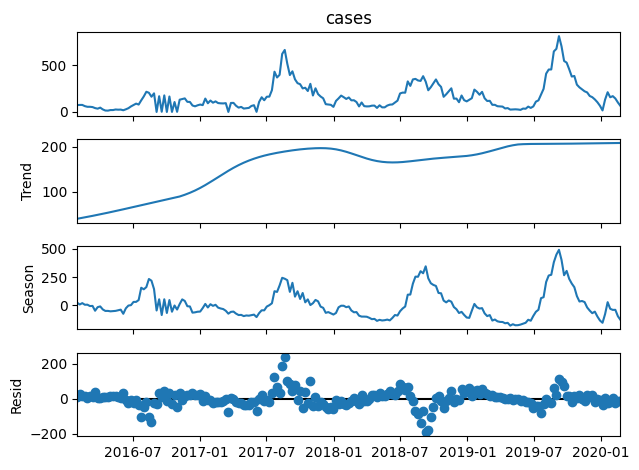

In [1015]:
stl = STL(qc_model_data['cases'], seasonal=53)
result = stl.fit()
result.plot()
plt.show()

In [1016]:
splitting_date = '10-01-2019'

train = qc_model_data[qc_model_data.index < splitting_date]
X_train = train.drop(columns = ['cases'])
y_train = train['cases']

test = qc_model_data[qc_model_data.index >= splitting_date]
X_test = test.drop(columns = ['cases'])
y_test = test['cases']

In [1017]:
import numpy as np
import xgboost as xgb

# Loss parameters
delta = 3  # Threshold for quadratic-linear transition
alpha = 5  # Asymmetry parameter (controls penalty for positive residuals)

def asymmetric_huber_loss(preds, dtrain):
    """
    Custom Asymmetric Huber Loss for XGBoost.
    
    preds: predicted values (f)
    dtrain: xgb.DMatrix with labels
    
    Returns: gradient and hessian
    """
    y = dtrain.get_label()
    r = y - preds  # Residuals

    # Compute masks for different residual regions
    mask_small = np.abs(r) <= delta
    mask_neg = r < -delta
    mask_pos = r > delta

    # Compute gradient (negative first derivative)
    grad = np.zeros_like(r)
    grad[mask_small] = r[mask_small]
    grad[mask_neg] = delta * np.sign(r[mask_neg])
    grad[mask_pos] = alpha * delta  # Increased penalty for positive residuals

    # Compute Hessian (second derivative)
    hess = np.zeros_like(r)
    hess[mask_small] = 1.0  # Only nonzero inside quadratic region

    return -grad, hess



In [1018]:
alpha = 0.2  # Underprediction errors (u > 0) are penalized with weight 1 - alpha = 0.7.
a = 5      # Threshold for the negative side.
b = 3    # Threshold for the positive side.

def generalized_huber_loss(preds, dtrain):
    """
    Custom generalized Huber loss for XGBoost.
    preds: predicted values (f)
    dtrain: DMatrix containing true labels.
    
    Returns:
      grad: Gradient vector.
      hess: Hessian vector.
    """
    y = dtrain.get_label()
    u = y - preds  # Compute residuals.

    # Initialize gradient and Hessian arrays.
    grad = np.zeros_like(u)
    hess = np.zeros_like(u)

    # Region 1: Moderate errors: -a <= u <= b.
    mask_mid = (u >= -a) & (u <= b)
    # For u >= 0: weight = (1 - alpha), for u < 0: weight = alpha.
    mask_mid_pos = mask_mid & (u >= 0)
    mask_mid_neg = mask_mid & (u < 0)
    grad[mask_mid_pos] = -(1 - alpha) * u[mask_mid_pos]
    grad[mask_mid_neg] = -alpha * u[mask_mid_neg]
    hess[mask_mid_pos] = (1 - alpha)
    hess[mask_mid_neg] = alpha

    # Region 2: Underpredictions beyond b (u > b): loss = (1 - alpha)*b*(u - b/2).
    mask_pos = u > b
    grad[mask_pos] = -(1 - alpha) * b
    hess[mask_pos] = 0.0

    # Region 3: Overpredictions beyond -a (u < -a): loss = -alpha*a*(u + 1/(2a)).
    mask_neg = u < -a
    grad[mask_neg] = -(-alpha * a)  # Simplifies to alpha * a (note: derivative is constant).
    # But note: since loss = -alpha*a*(u + 1/(2a)), derivative with respect to u is -alpha*a.
    # Then gradient with respect to f is - (d(loss)/du) = alpha*a.
    grad[mask_neg] = alpha * a
    hess[mask_neg] = 0.0

    return grad, hess

In [1019]:
X = train.drop(columns = ['cases'])
y = train['cases']

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective':'reg:squarederror'
}

# Train the model using our custom loss function
num_boost_round = 200
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
# bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = bst.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Save the model
bst.save_model("xgb_quantile_huber.model")


Mean Absolute Error (MAE): 56.7444
Mean Squared Error (MSE): 5406.6858


d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


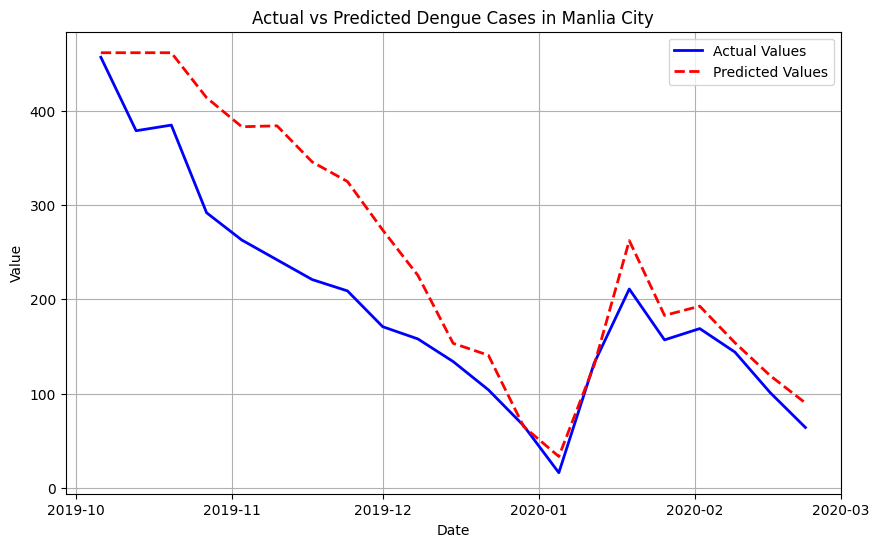

In [1020]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Dengue Cases in Manlia City')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()

In [1021]:
mnl_model_data = NCR_model_data[NCR_model_data['loc'] == 'MANILA CITY']
mnl_model_data.set_index('date',inplace=True)
mnl_model_data.drop(columns = ['loc'],inplace=True)
mnl_model_data = mnl_model_data.apply(pd.to_numeric, errors='coerce')
mnl_model_data = mnl_model_data[mnl_model_data.index < '2020-03-01']
mnl_model_data = mnl_model_data.asfreq('W')
mnl_model_data['cases'] = mnl_model_data['cases'].interpolate()
mnl_model_data.head()

D:\Temp\ipykernel_9032\858934221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnl_model_data.drop(columns = ['loc'],inplace=True)


,cases,cases 2w lag,3wma cases 2w lag,6wma cases 2w lag,cases 5w lag,3wma cases 5w lag,6wma cases 5w lag,cases 3w lag,3wma cases 3w lag,6wma cases 3w lag,cases 26w lag,3wma cases 26w lag,6wma cases 26w lag,cases 52w lag,3wma cases 52w lag,6wma cases 52w lag,month
date,,,,,,,,,,,,,,,,,
2016-01-31,31.0,13.0,16.333333,16.333333,30.0,16.333333,16.333333,9.0,16.333333,16.333333,81.0,16.333333,16.333333,4.0,16.333333,16.333333,1.0
2016-02-07,33.0,15.0,17.666667,18.000000,28.0,17.666667,18.000000,10.0,17.666667,18.000000,85.0,17.666667,18.000000,5.0,17.666667,18.000000,2.0
2016-02-14,33.0,15.0,17.666667,18.000000,28.0,17.666667,18.000000,10.0,17.666667,18.000000,73.0,17.666667,18.000000,5.0,17.666667,18.000000,2.0
2016-02-21,36.0,9.0,17.333333,17.500000,26.0,17.333333,17.500000,9.0,17.333333,17.500000,75.0,17.333333,17.500000,5.0,17.333333,17.500000,2.0
2016-02-28,32.0,13.0,18.333333,18.666667,39.0,18.333333,18.666667,6.0,18.333333,18.666667,75.0,18.333333,18.666667,5.0,18.333333,18.666667,2.0


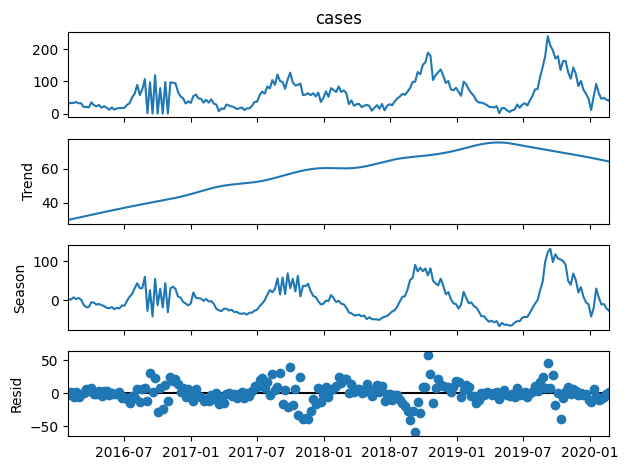

In [1022]:
stl = STL(mnl_model_data['cases'], seasonal=53)
result = stl.fit()
result.plot()
plt.show()

In [1023]:
splitting_date = '10-01-2019'
# splitting_date = '06-01-2019'

train = mnl_model_data[mnl_model_data.index < splitting_date]
X_train = train.drop(columns = ['cases'])
y_train = train['cases']

test = mnl_model_data[mnl_model_data.index >= splitting_date]
X_test = test.drop(columns = ['cases'])
y_test = test['cases']

In [1024]:
X = train.drop(columns = ['cases'])
y = train['cases']

# Convert to XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective':'reg:squarederror'
}

# Train the model using our custom loss function
num_boost_round = 200
# bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = bst.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Save the model
bst.save_model("xgb_quantile_huber.model")


Mean Absolute Error (MAE): 10.1348
Mean Squared Error (MSE): 157.9534


d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


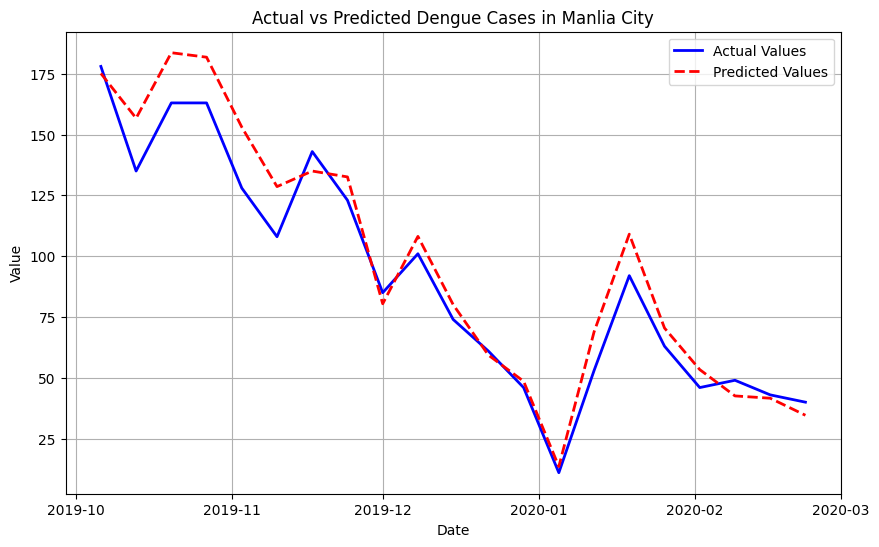

In [1025]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Dengue Cases in Manlia City')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()

Training fraction: 70% | Test MSE: 252.9672


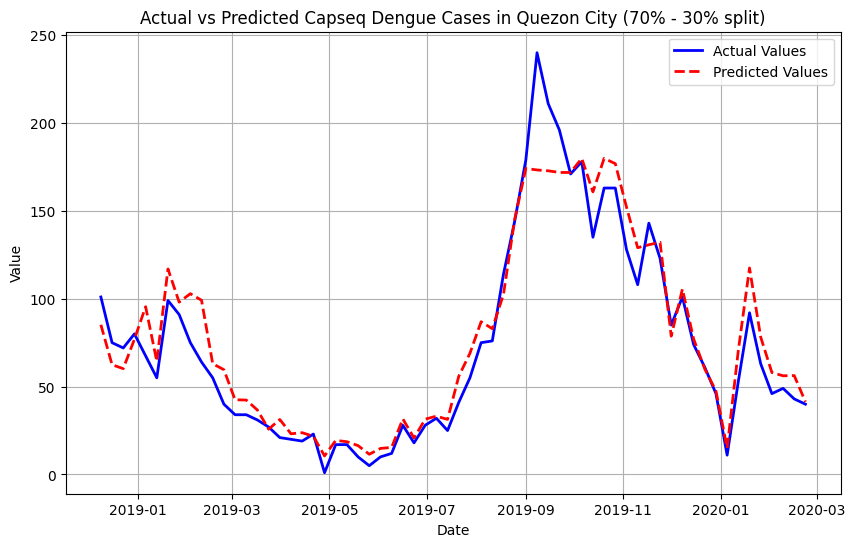

Training fraction: 80% | Test MSE: 292.8584


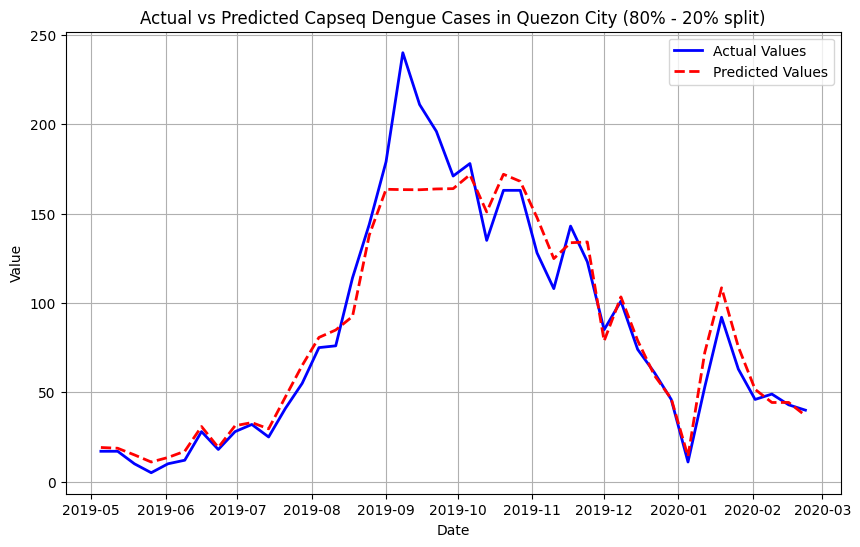

Training fraction: 90% | Test MSE: 132.0711


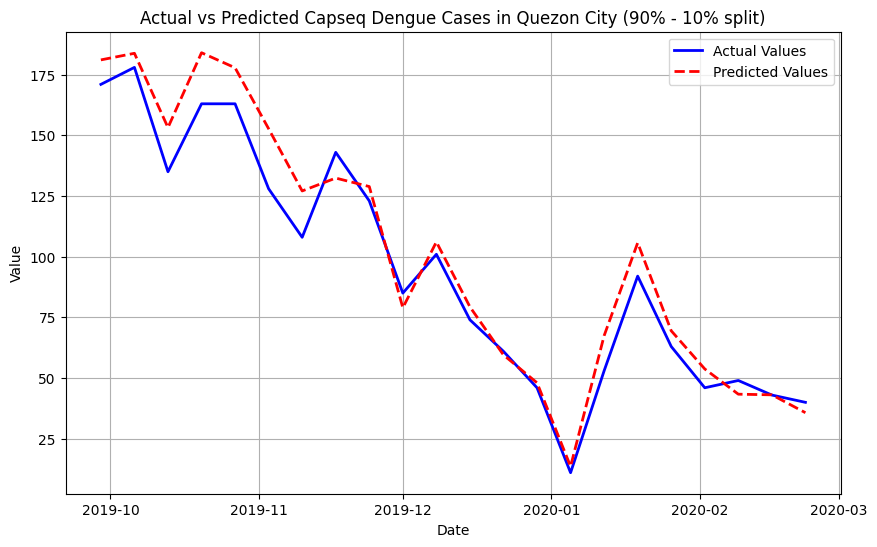

In [1026]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Assume 'df' is your DataFrame and it's sorted by time (if applicable).
# For example:
# df = pd.read_csv("your_data.csv")
# df.sort_values("date", inplace=True)
df =mnl_model_data
n = len(df)
fractions = [0.7, 0.8, 0.9]
results = []

for frac in fractions:
    train_size = int(frac * n)
    # Use the first 'train_size' rows as the training set
    train_data = df.iloc[:train_size]
    # Use the remaining rows as the test set (if any)
    test_data = df.iloc[train_size:]
    
    # Prepare XGBoost DMatrix objects
    dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
    if not test_data.empty:
        dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
    else:
        dtest = None

    # Define XGBoost parameters (adjust as needed)
    params = {
        'max_depth': 4,
        'eta': 0.1,
        'objective': 'reg:squarederror'  # Replace with your custom objective if needed
    }
    
    num_boost_round = 100
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Evaluate the model on test data if available
    if dtest is not None:
        preds = model.predict(dtest)
        mse = mean_squared_error(test_data['cases'], preds)
        results.append((frac, mse))
        print(f"Training fraction: {frac*100:.0f}% | Test MSE: {mse:.4f}")
    else:
        results.append((frac, None))
        print(f"Training fraction: {frac*100:.0f}% | No test data available.")
# 'results' now holds the training fraction and corresponding test MSE values.
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(test_data.index, preds, label='Predicted Values', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted Capseq Dengue Cases in Quezon City ({frac*100:.0f}% - {(1-frac)*100:.0f}% split)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

Training fraction: 70% | Test MSE: 1515.1824


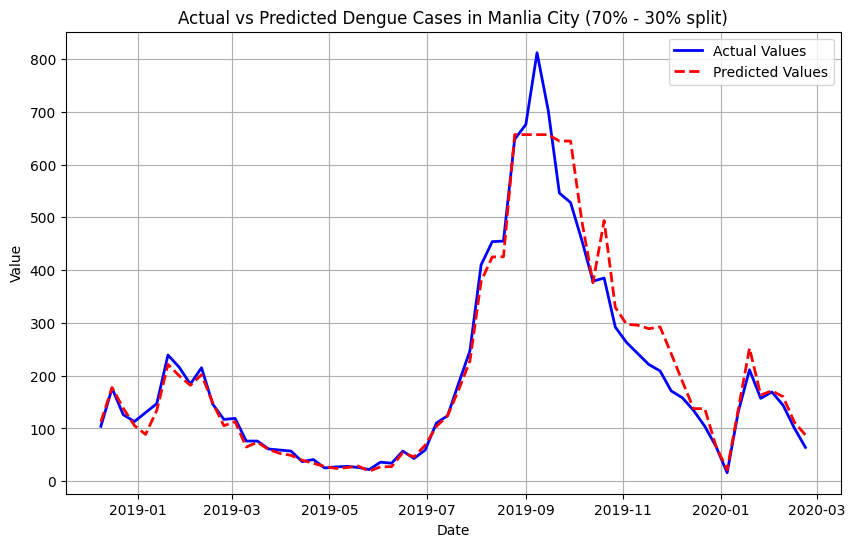

Training fraction: 80% | Test MSE: 2216.7820


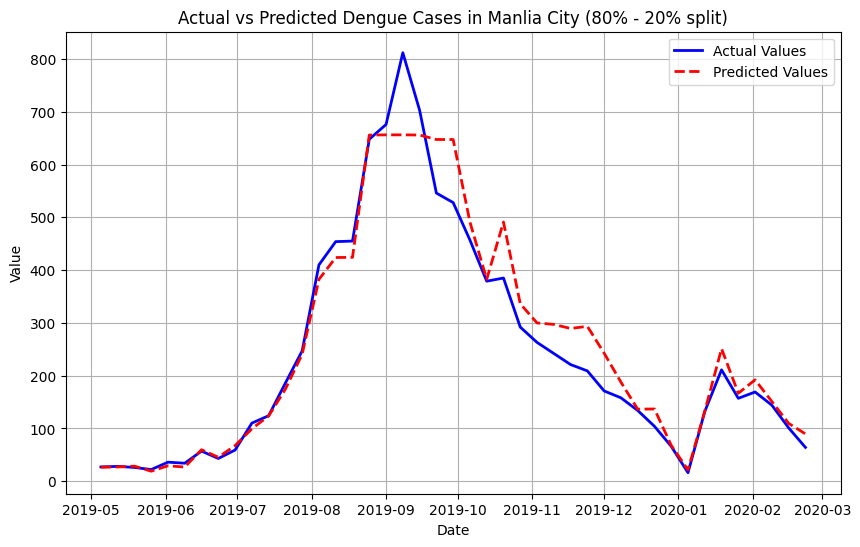

Training fraction: 90% | Test MSE: 2540.5876


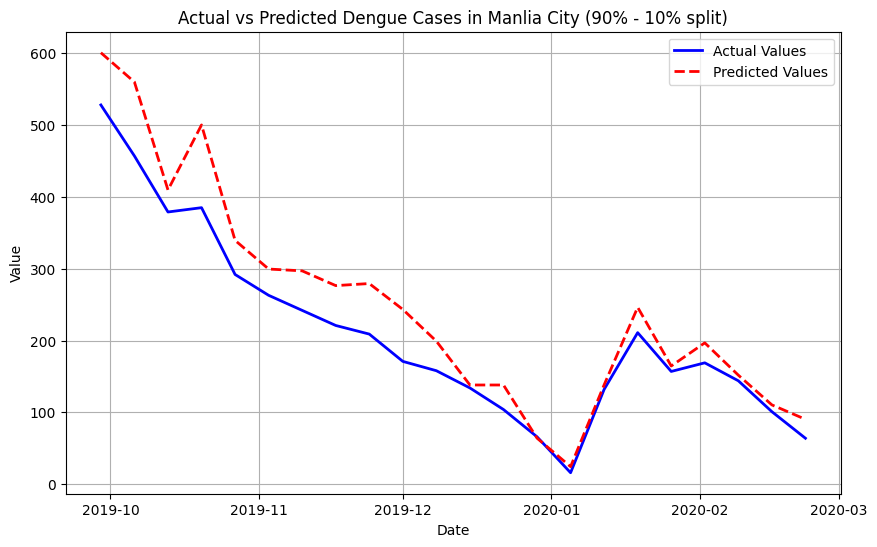

In [1027]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Assume 'df' is your DataFrame and it's sorted by time (if applicable).
# For example:
# df = pd.read_csv("your_data.csv")
# df.sort_values("date", inplace=True)
df =qc_model_data
n = len(df)
fractions = [0.7, 0.8, 0.9]
results = []

for frac in fractions:
    train_size = int(frac * n)
    # Use the first 'train_size' rows as the training set
    train_data = df.iloc[:train_size]
    # Use the remaining rows as the test set (if any)
    test_data = df.iloc[train_size:]
    
    # Prepare XGBoost DMatrix objects
    dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
    if not test_data.empty:
        dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
    else:
        dtest = None

    # Define XGBoost parameters (adjust as needed)
    params = {
        'max_depth': 4,
        'eta': 0.1,
        'objective': 'reg:squarederror'  # Replace with your custom objective if needed
    }
    
    num_boost_round = 100
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Evaluate the model on test data if available
    if dtest is not None:
        preds = model.predict(dtest)
        mse = mean_squared_error(test_data['cases'], preds)
        results.append((frac, mse))
        print(f"Training fraction: {frac*100:.0f}% | Test MSE: {mse:.4f}")
    else:
        results.append((frac, None))
        print(f"Training fraction: {frac*100:.0f}% | No test data available.")
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(test_data.index, preds, label='Predicted Values', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted Dengue Cases in Manlia City ({frac*100:.0f}% - {(1-frac)*100:.0f}% split)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
# 'results' now holds the training fraction and corresponding test MSE values.
